# EDA & Preprocessing for Regression Dataset

## Setup & Imports

In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bagging_boosting_stacking_study.data.loaders import load_dataset

## 1. Load Data

In [3]:
df = load_dataset("friedman3")

## 2. Initial Data Inspection

In [4]:
# Summary of dataset dimensions
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Overview of each column’s data type and counts of non-null entries
print("\nColumn Data Types and Non-Null Counts:")
print(df.info())

# Tally of missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Immediate red flags
print("\nImmediate Red Flags:")
# Check for all-zero columns
all_zero_columns = [col for col in df.columns if (df[col] == 0).all()]
if all_zero_columns:
    print(f"Columns with all zeros: {all_zero_columns}")
else:
    print("No columns with all zeros.")

# Check for duplicated rows
duplicated_rows = df.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_rows}")

Dataset contains 200 rows and 5 columns.

Column Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  200 non-null    float64
 1   feature_1  200 non-null    float64
 2   feature_2  200 non-null    float64
 3   feature_3  200 non-null    float64
 4   target     200 non-null    float64
dtypes: float64(5)
memory usage: 7.9 KB
None

Missing Values:
Series([], dtype: int64)

Immediate Red Flags:
No columns with all zeros.
Number of duplicated rows: 0


## 3. Univariate Descriptions

In [5]:
# Stats like: mean, std, min, max and quartiles for numeric columns

numeric_df = df.select_dtypes(include=[np.number])
desc_stats = numeric_df.describe().T
print(desc_stats)

           count        mean         std         min         25%         50%  \
feature_0  200.0   46.390550   28.824750    0.168031   21.817391   45.523091   
feature_1  200.0  958.243561  457.922182  136.464980  556.795941  967.254838   
feature_2  200.0    0.479634    0.295911    0.000727    0.226890    0.460155   
feature_3  200.0    5.986414    3.001289    1.058070    3.374736    5.906500   
target     200.0    1.296405    0.422367   -0.192801    1.093806    1.345078   

                   75%          max  
feature_0    70.737260    98.792213  
feature_1  1370.310554  1758.440172  
feature_2     0.736636     0.994519  
feature_3     8.690738    10.998138  
target        1.579467     2.324179  


In [6]:
# Skewness and outlier counts
numeric_df = df.select_dtypes(include=[np.number])
skewness = numeric_df.skew()
iqr_outlier_counts = {}
z_outlier_counts = {}
outlier_index_info = {}
for col in numeric_df.columns:
    series = numeric_df[col]
    
    # IQR-based outliers
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    iqr_mask = (series < lower) | (series > upper)
    iqr_outlier_counts[col] = iqr_mask.sum()
    
    # Z-score–based outliers (|z| > 3)
    mean, std = series.mean(), series.std()
    z_scores = (series - mean) / std
    z_mask = np.abs(z_scores) > 3
    z_outlier_counts[col] = z_mask.sum()

outlier_index_info[col] = {
        "iqr_indices": series.index[iqr_mask].tolist(),
        "z_indices": series.index[z_mask].tolist()
    }

skew_outliers_df = pd.DataFrame({
    "skewness": skewness,
    "iqr_outliers": pd.Series(iqr_outlier_counts),
    "z_outliers": pd.Series(z_outlier_counts)
})
print(skew_outliers_df.round(2))

print("\nOutlier indices by column:")
for col, idxs in outlier_index_info.items():
    print(f"{col}: IQR: {idxs['iqr_indices']}, Z-score: {idxs['z_indices']}")

           skewness  iqr_outliers  z_outliers
feature_0      0.12             0           0
feature_1     -0.05             0           0
feature_2      0.09             0           0
feature_3      0.01             0           0
target        -0.70             8           1

Outlier indices by column:
target: IQR: [11, 52, 103, 124, 134, 149, 150, 191], Z-score: [149]


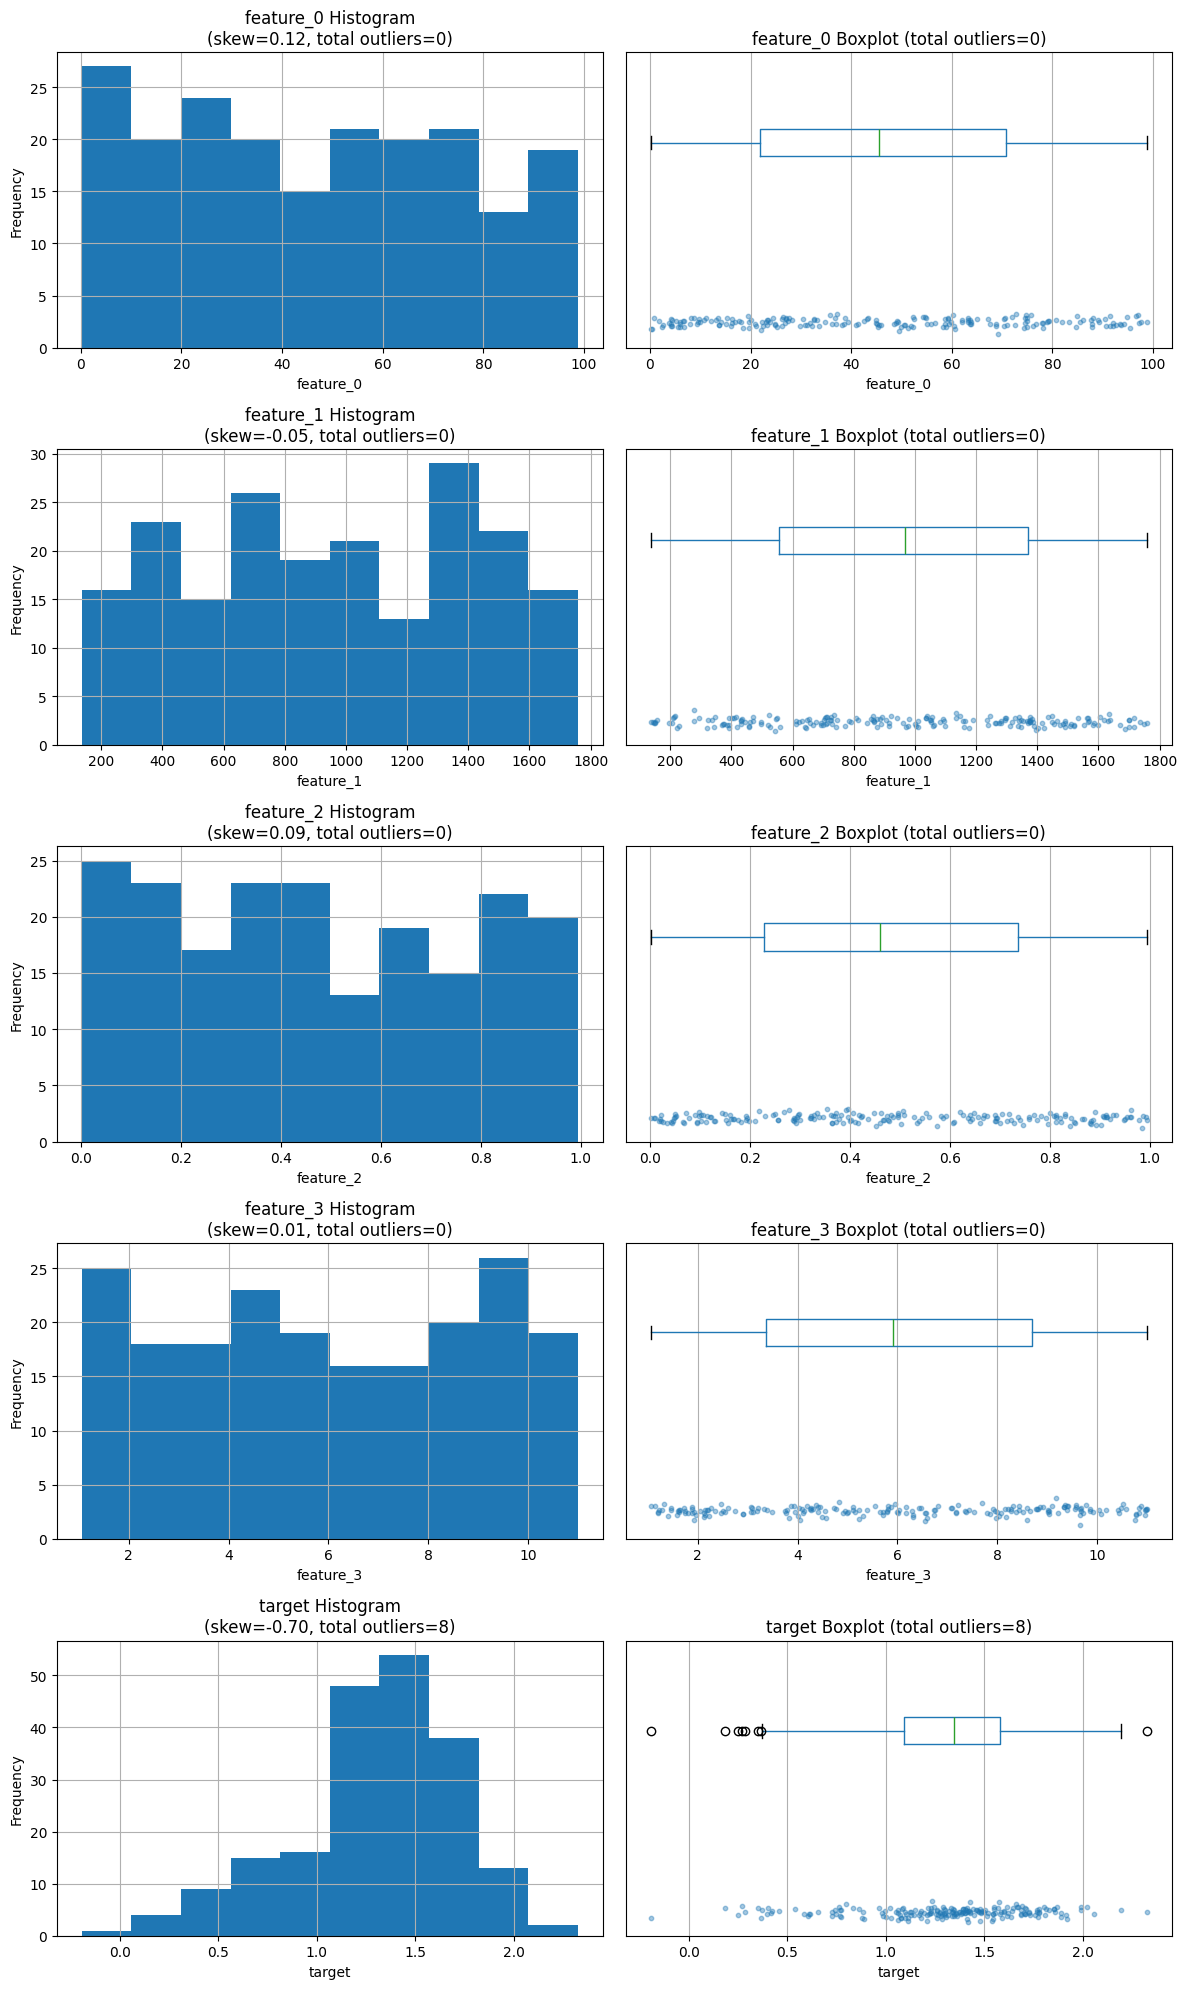

In [7]:
# Plots for skewness and outliers

features = list(numeric_df.columns)
n = len(features)

# Grid of subplots: 5 rows, 2 columns
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))

for i, col in enumerate(features):
    skew_val = skewness[col]
    out_count = iqr_outlier_counts[col]
    # Histogram
    ax_hist = axes[i, 0]
    numeric_df[col].hist(ax=ax_hist)
    ax_hist.set_title(f"{col} Histogram\n(skew={skew_val:.2f}, total outliers={out_count})")
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel("Frequency")
    # Boxplot + jitter
    ax_box = axes[i, 1]
    numeric_df.boxplot(column=col, ax=ax_box, vert=False, showfliers=True)
    y_jitter = np.random.normal(loc=0, scale=0.02, size=len(numeric_df))
    ax_box.scatter(numeric_df[col], y_jitter, alpha=0.4, s=10)
    ax_box.set_title(f"{col} Boxplot (total outliers={out_count})")
    ax_box.set_xlabel(col)
    ax_box.set_yticks([])

plt.tight_layout()
plt.show()

Target variable 'y' statistics:
- Range: -0.19 to 2.32
- Mean: 1.30, Median: 1.35
- Skewness: -0.70 (left-skewed)
- Kurtosis: 0.62 (mesokurtic (similar to normal))
- Modality: unimodal


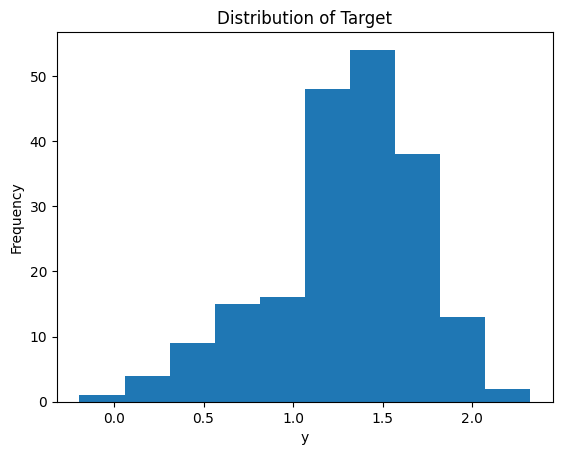

In [8]:
y = df['target']

# Compute basic statistics for target column
y_min, y_max = y.min(), y.max()
y_mean, y_median = y.mean(), np.median(y)
y_skew = pd.Series(y).skew()
y_kurt = pd.Series(y).kurtosis()

# Assess distribution shape

# Skewness-based symmetry
if abs(y_skew) < 0.5:
    symmetry = "approximately symmetric"
elif y_skew > 0.5:
    symmetry = "right-skewed"
else:
    symmetry = "left-skewed"

# Kurtosis-based tails
if y_kurt > 1:
    tail_desc = "heavy-tailed"
elif y_kurt < -1:
    tail_desc = "light-tailed"
else:
    tail_desc = "mesokurtic (similar to normal)"

# Peak detection for modality
hist_counts, bin_edges = np.histogram(y, bins=10)
peaks = [i for i in range(1, len(hist_counts)-1) 
         if hist_counts[i] > hist_counts[i-1] and hist_counts[i] > hist_counts[i+1]]
modality = "multimodal" if len(peaks) > 1 else "unimodal"

# Print results
print(f"Target variable 'y' statistics:")
print(f"- Range: {y_min:.2f} to {y_max:.2f}")
print(f"- Mean: {y_mean:.2f}, Median: {y_median:.2f}")
print(f"- Skewness: {y_skew:.2f} ({symmetry})")
print(f"- Kurtosis: {y_kurt:.2f} ({tail_desc})")
print(f"- Modality: {modality}")

# Histogram
plt.figure()
plt.hist(y, bins=10)
plt.title("Distribution of Target")
plt.xlabel("y")
plt.ylabel("Frequency")
plt.show()

There are no categorical or descrete columns in this dataset.

## 4. Outlier & Missing-Value Analysis

In [9]:
print(skew_outliers_df[["iqr_outliers", "z_outliers"]])

print("\nOutlier indices by column:")
for col, idxs in outlier_index_info.items():
    print(f"{col}: IQR: {idxs['iqr_indices']}, Z-score: {idxs['z_indices']}")   


           iqr_outliers  z_outliers
feature_0             0           0
feature_1             0           0
feature_2             0           0
feature_3             0           0
target                8           1

Outlier indices by column:
target: IQR: [11, 52, 103, 124, 134, 149, 150, 191], Z-score: [149]


## Conclusion for outliers
The only column that contains outliers is target column. Because Friedman3 dataset is synthetic, those outliers simply reflect the noise distribution. Dropping or capping them woulld bias the error estimates downward. Therefore, it's better to leave those outliers as they are and potentially use Huber/Tukey loss when fitting models (where it will be possible) so that the residuals beyond a threshold aren't weighted as heavily.

In [10]:
# # Missing values
print(df.isnull().sum())

feature_0    0
feature_1    0
feature_2    0
feature_3    0
target       0
dtype: int64


## Conclusion for missing values
No missing values in this dataset.

## 5. Correlation Analysis


Pairwise correlations:
feature_0 vs feature_0: 1.00
feature_0 vs feature_1: -0.22
feature_0 vs feature_2: -0.01
feature_0 vs feature_3: 0.10
feature_0 vs target: -0.29
feature_1 vs feature_0: -0.22
feature_1 vs feature_1: 1.00
feature_1 vs feature_2: 0.09
feature_1 vs feature_3: -0.09
feature_1 vs target: 0.35
feature_2 vs feature_0: -0.01
feature_2 vs feature_1: 0.09
feature_2 vs feature_2: 1.00
feature_2 vs feature_3: 0.03
feature_2 vs target: 0.39
feature_3 vs feature_0: 0.10
feature_3 vs feature_1: -0.09
feature_3 vs feature_2: 0.03
feature_3 vs feature_3: 1.00
feature_3 vs target: -0.12
target vs feature_0: -0.29
target vs feature_1: 0.35
target vs feature_2: 0.39
target vs feature_3: -0.12
target vs target: 1.00


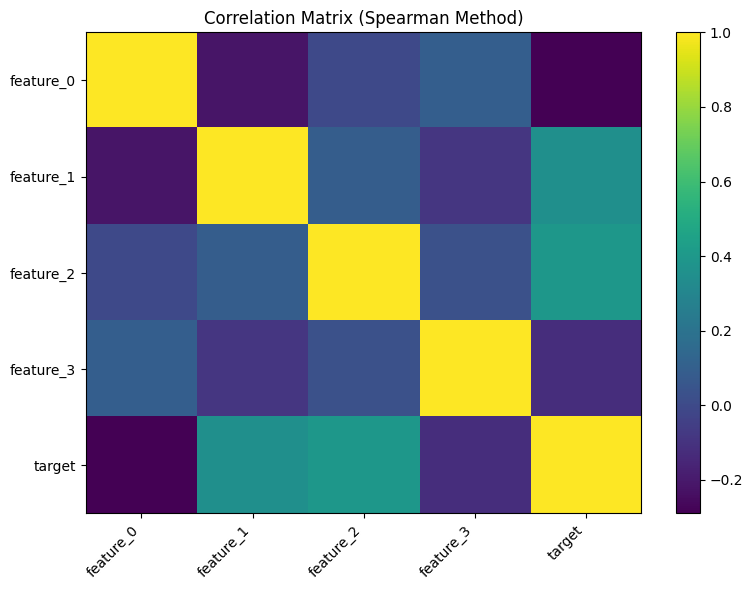

In [11]:
# Determine skewness and choose correlation method
skew_vals = skewness.abs()
method = 'spearman' if (skew_vals > 0.5).any() else 'pearson'

# Compute correlation matrix
corr_matrix = numeric_df.corr(method=method)

# Print each pairwise correlation individually
print("\nPairwise correlations:")
for i in corr_matrix.index:
    for j in corr_matrix.columns:
        print(f"{i} vs {j}: {corr_matrix.loc[i, j]:.2f}")

# Heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.colorbar(im)
plt.title(f'Correlation Matrix ({method.capitalize()} Method)')
plt.tight_layout()
plt.show()

In [12]:
threshold = 0.5
strong_pairs = []

# Identify feature-feature correlations (excluding self-correlations)
features = corr_matrix.columns.tolist()
for i, feat_i in enumerate(features):
    for feat_j in features[i+1:]:
        corr_val = corr_matrix.loc[feat_i, feat_j]
        if abs(corr_val) > threshold:
            strong_pairs.append((feat_i, feat_j, corr_val))

# Identify feature-target correlations
target_corr = []
if 'y' in features:
    for feat in [f for f in features if f != 'y']:
        corr_val = corr_matrix.loc[feat, 'y']
        if abs(corr_val) > threshold:
            target_corr.append((feat, corr_val))

# Print results
print(f"Strong correlations (|corr| > {threshold}, using {method}):\n")

if target_corr:
    print("Features strongly correlated with target:")
    for feat, val in target_corr:
        print(f"- {feat} and y have a correlation of {val:.2f}, indicating good predictive power.")
    print()

if strong_pairs:
    print("Feature pairs with high inter-correlation:")
    for a, b, val in strong_pairs:
        print(f"- {a} and {b} have a correlation of {val:.2f}, indicating potential redundancy or multicollinearity.")
else:
    print("No feature pairs exceed the high-correlation threshold.")

Strong correlations (|corr| > 0.5, using spearman):

No feature pairs exceed the high-correlation threshold.


## Conclusion for correlations between columns
There is no correlation of value 0.5 or above. There are no surprising off-diagonal hotspots in the heatmap. The low correlations among features confirm they’re indeed independent.

## 6. Multivariate Exploration

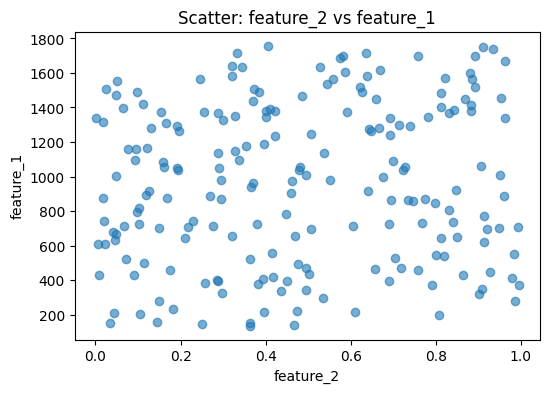

feature_2 vs feature_1: Points are uniformly scattered with no obvious linear trend.


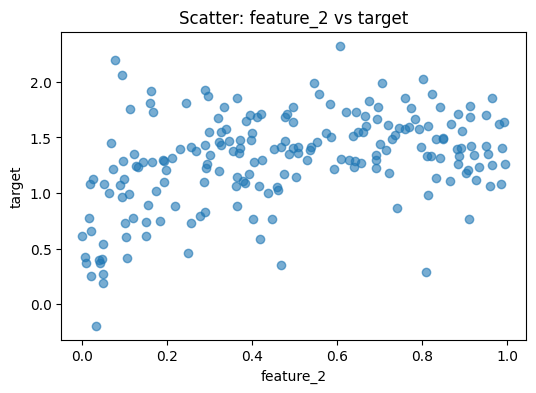

feature_2 vs target: Shows a non-linear, increasing trend with heteroscedastic spread.


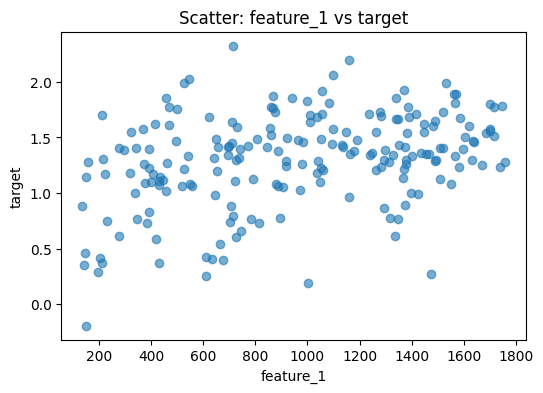

feature_1 vs target: Exhibits a curved relationship, indicating a non-linear signal component.


In [13]:
# Identify top 2 features by absolute correlation with target
abs_corr_with_y = corr_matrix['target'].abs().drop('target')
top_feats = abs_corr_with_y.sort_values(ascending=False).index[:2].tolist()

# Prepare pairs: feature–feature and feature–target
pairs = list(combinations(top_feats, 2)) + [(feat, 'target') for feat in top_feats]

# Plot each scatter and print a descriptive comment below
for feat_x, feat_y in pairs:
    plt.figure(figsize=(6, 4))
    y_vals = df['target'] if feat_y == 'target' else numeric_df[feat_y]
    plt.scatter(numeric_df[feat_x], y_vals, alpha=0.6)
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.title(f"Scatter: {feat_x} vs {feat_y}")
    plt.show()
    
    if feat_y == 'target':
        if feat_x == top_feats[0]:
            print(f"{feat_x} vs target: Shows a non-linear, increasing trend with heteroscedastic spread.")
        else:
            print(f"{feat_x} vs target: Exhibits a curved relationship, indicating a non-linear signal component.")
    else:
        print(f"{feat_x} vs {feat_y}: Points are uniformly scattered with no obvious linear trend.")

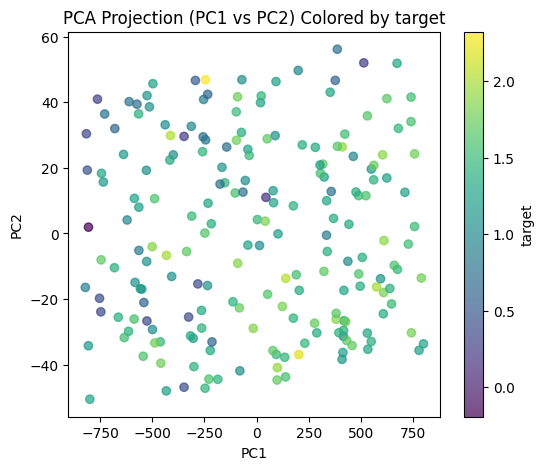

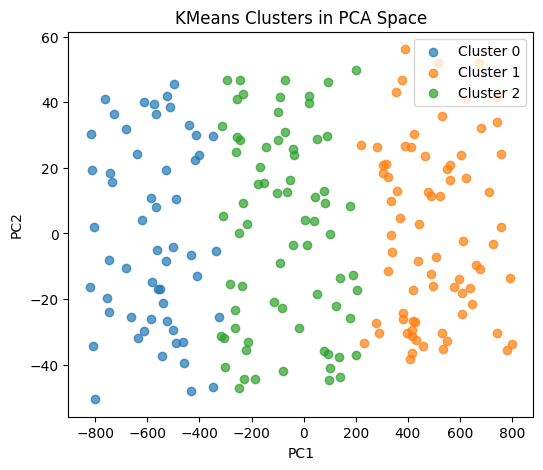

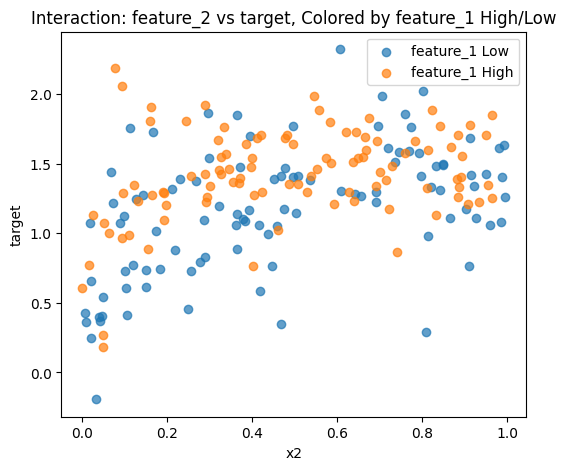

In [14]:
SEED = 333
# PCA projection to 2D
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(numeric_df)
df_pca = df.copy()
df_pca['PC1'], df_pca['PC2'] = X_pca[:, 0], X_pca[:, 1]

# Scatter PC1 vs PC2 colored by target y
plt.figure(figsize=(6, 5))
sc = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['target'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='target')
plt.title('PCA Projection (PC1 vs PC2) Colored by target')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# KMeans clustering in PCA space
kmeans = KMeans(n_clusters=3, random_state=SEED)
df_pca['cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

plt.figure(figsize=(6, 5))
for cluster in sorted(df_pca['cluster'].unique()):
    mask = df_pca['cluster'] == cluster
    plt.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
                label=f'Cluster {cluster}', alpha=0.7)
plt.title('KMeans Clusters in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Interaction effect: feature_2 vs y colored by high vs low feature_2
median_x1 = df['feature_1'].median()
low_mask  = df['feature_1'] <= median_x1 # above median, high target
high_mask = df['feature_1'] > median_x1 # below median, low target

plt.figure(figsize=(6, 5))
plt.scatter(df.loc[low_mask, 'feature_2'], df.loc[low_mask, 'target'], label='feature_1 Low', alpha=0.7)
plt.scatter(df.loc[high_mask, 'feature_2'], df.loc[high_mask, 'target'], label='feature_1 High', alpha=0.7)
plt.title('Interaction: feature_2 vs target, Colored by feature_1 High/Low')
plt.xlabel('x2')
plt.ylabel('target')
plt.legend()
plt.show()

## Conclusion for PCA Analysis

### Understanding PC1 vs PC2  
We transformed our four original features into two new axes—PC1 and PC2—that capture the most variation in the data.  
- **One cohesive cloud**  
  All samples lie in a single, roughly uniform group. This confirms that **feature_0** through **feature_3** were generated independently and don’t form separate clusters.  
- **Target gradient along PC1**  
  When we color points by their **target** value, lighter (higher-target) points tend to appear on the right side (higher PC1). This tells us PC1 aligns with the main signal driving the target.  
- **No odd “folds” or branches**  
  The points fill out a smooth shape without bending back on themselves, indicating there’s no hidden, complex manifold structure.



### K-Means Clustering in PCA Space  
We overlaid three K-Means clusters on the same PC1–PC2 plot.  
- **Striped layout**  
  The algorithm splits the cloud into three vertical bands, but these bands are purely an artifact of the clustering procedure—not real groups in the data.  
- **Mixed target values**  
  Each band contains a mix of low and high target points, so the clusters don’t correspond to different target levels.  
- **Key takeaway**  
  There is **no natural segmentation** in this dataset—any cluster labels would serve only as arbitrary groupings for tasks like stratified sampling.



### Interaction: feature_2 vs. target, Colored by feature_1 Level  
We divided observations into “feature_1 low” and “feature_1 high” (split at the median) to see how **feature_2** interacts with the **target**.  
- **Curved relationship in both groups**  
  In both colors, target rises with feature_2 along a gently curved path—evidence of a non-linear effect.  
- **Vertical offset for high feature_1**  
  Orange points (feature_1 high) sit consistently above blue points at the same feature_2 value, showing that higher feature_1 amplifies the feature_2 (target effect).  
- **Wider spread in the middle**  
  The variability of the target is greatest at mid-range feature_2 values when feature_1 is high, highlighting where the two-way interaction is strongest.



### Overall Insights  
- **Features are independent**—no hidden clusters or colinear groups.  
- **Target signal aligns with PC1**, confirming that most information about the target is captured in one direction.  
- **A clear interaction** between feature_1 and feature_2 affects the target, so our model should be able to learn non-linear effects and feature interactions (tree-based methods or polynomial expansions).


## 7. Feature Engineering Plan

### 1. Core Numeric Transformations  
- **No heavy skew corrections for inputs**  
  All four features (`feature_0`–`feature_3`) are nearly uniform (|skew| < 0.2), so we leave them untransformed for tree-based models; we will only apply scaling when needed by linear/KNN learners.  
- **Optional Yeo–Johnson on target**  
  If we include a linear meta-learner in our stacking stack, we might consider Yeo–Johnson transform on **target** to reduce its mild left skew (≈ –0.7).

### 2. Scaling / Normalization  
- **Tree models (bagging/boosting)**: No scaling required.  
- **Linear/KNN components**:  
  - We will use `StandardScaler` (zero mean, unit variance) in a `ColumnTransformer`.  
  - Alternatively, `MinMaxScaler` for [0–1] bounds for distance-based learners.

### 3. Derived Feature Ideas  
- **Pairwise interaction**  
  - `feature_1 * feature_2` (captures the known synergy in Friedman-3).  
- **Polynomial features**  
  - Including `feature_1²` and `feature_2²` to help linear methods approximate the curved response.  
- **Binning of continuous inputs**  
  - Discretizing `feature_2` into 3 bins (`low`/`medium`/`high`), one-hot encode; gives simple step functions that trees can split on.  
- **Ratios / differences**  
  - Optionally trying `feature_2 – feature_1` or `feature_1 / (feature_2 + ε)` for exploratory signals.

### 4. Categorical Encoding (if introduced)  
- **One-hot encoding** for any synthetic bins or new categorical features.  
- **Group rare levels** under `'Other'` if frequency < 5%.

### 5. Model-Specific Rationale  
| Strategy    | Benefits                                                                                                                                                                     |
|-------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Bagging** | - Works well with raw features & binned categories—deep trees capture interactions automatically.<br>- Reduces variance by averaging many decorrelated models.                 |
| **Boosting**| - Benefits from explicit interaction & polynomial terms to speed up learning in shallow trees; scaling is irrelevant.<br>- Sequential fitting reduces bias and focuses on hard‐to‐predict points. |
| **Stacking**| - Leverages diverse base learners (bagging, boosting, linear) to combine complementary strengths.<br>- Uses a linear meta‐learner to optimally and interpretably weight each model’s predictions.<br>- Incorporates multiple feature representations (raw, scaled, polynomial, binned) to increase ensemble diversity.<br>- Applies regularization on the meta‐learner to prevent over‐reliance on any single base model. |
  


### 7. Validation & Effectiveness  
1. **Feature importance**  
   - Fit a `RandomForestRegressor` and a `GradientBoostingRegressor`; compare their `.feature_importances_`.  
   - Check which engineered terms (e.g. `feature_1*feature_2`, `feature_2²`) show high importance.  
2. **Cross-validation**  
   - Run 5-fold CV on:  
     - Baseline (raw features)  
     - + Scaling & target transform  
     - + Polynomial & interaction terms  
     - + Binned features  
   - Track RMSE improvements to quantify each group’s impact.  
3. **Ablation study**  
   - Remove one feature group at a time (e.g. interactions, polynomials) to measure performance drop.  
4. **Stacked pipeline test**  
   - **Level-0**:  
     - RandomForest (raw)  
     - GradientBoosting (with interactions)  
     - LinearRegressor (scaled + poly)  
   - **Level-1**: Linear meta-learner on the combined predictions.  
### 5. Validation & Effectiveness  
**Quick global check with Permutation Importance**  
   - We will run `permutation_importance` on our trained models in order to confirm that `feature_1`, `feature_2`, and any engineered interactions rank highest, while `feature_0`/`feature_3` remain low.  

**In-depth local & global insights with SHAP**  
   - We will use `shap.TreeExplainer` on our best tree-based model to get per-sample Shapley values
   - We will inspect **force plots** for a few examples (e.g. extreme targets) to see how each term pushes the prediction.

By combining **fast, global** permutation importance with **detailed, local** SHAP explanations, we'll confirm that our engineered features are genuinely driving improvements—both overall and on individual predictions.  

## 8. Preprocessing Pipeline Outline

### 1. Missing-Value Imputation  
- **Assess**: `df.isnull().sum()`--> all zeros.  
- **Action**: No imputation needed (no missing values present).



### 2. Outlier Handling  
- **Assess**: Only **target** has 8 IQR outliers; **features** have none.  
- **Action**: Leave target outliers as-is (they reflect synthetic noise). Do not cap or drop any values.



### 3. Feature Transforms & Scaling  
1. **Derived features**  
   - `feature_1 * feature_2`  
   - `feature_1**2`, `feature_2**2`  
   - Bin `feature_2` into 3 equal-width bins --> one-hot encode (`feature_2_low`, `feature_2_med`, `feature_2_high`)  
2. **Scaling**  
   - **Tree-based models** (RandomForest, GradientBoosting): no scaling  
   - **Linear/KNN models**:  
     ```python
     from sklearn.preprocessing import StandardScaler
     scaler = StandardScaler()
     X_scaled = scaler.fit_transform(X[['feature_0','feature_1','feature_2','feature_3', 'feature_1*feature_2', 'feature_1^2','feature_2^2']])
     ```
3. **Target transform (optional)**  
   - If using a linear meta-learner in stacking, apply Yeo–Johnson to `target`.



### 4. Train/Test Split  
```python
from sklearn.model_selection import train_test_split

X, y = df.drop(columns='target'), df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=333
)

# Pipeline steps documented in JSON:

In [15]:
# Commented in order not to generate errors when running

# {
#   "friedman3_pipeline": {
#     "imputation": { "required": false },
#     "outlier_handling": {
#       "target": "leave_as_is",
#       "features": "none_detected"
#     },
#     "feature_engineering": {
#       "interactions": [["feature_1", "feature_2"]],
#       "polynomial": {
#         "degree": 2,
#         "features": ["feature_1", "feature_2"]
#       },
#       "binning": {
#         "feature": "feature_2",
#         "bins": 3,
#         "encode": "one_hot"
#       }
#     },
#     "scaling": {
#       "tree_models": "none",
#       "linear_knn": {
#         "method": "StandardScaler",
#         "features": ["feature_0","feature_1","feature_2","feature_3","feature_1*feature_2","feature_1^2","feature_2^2"]
#       }
#     },
#     "split": {
#       "test_size": 0.2,
#       "random_state": 333
#     },
#     "output": {
#       "directory": "data/processed/friedman3",
#       "formats": ["csv","pickle"],
#       "filenames": {
#         "train": { "csv": "friedman3_train.csv", "pickle": "friedman3_train.pkl" },
#         "test":  { "csv": "friedman3_test.csv",  "pickle": "friedman3_test.pkl" }
#       }
#     }
#   }
# }
